In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  #

In [2]:
import torch

torch.cuda.is_available()

/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [3]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [4]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [5]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [6]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["8b80aa05d88b518b"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [8]:
EXPERIMENT_NAME = "pdm_closed_pdm_closed_diverge_impure_scen_1400"

scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=1400",  # use 10 scenarios per scenario type #bring this back to 25 for testing the cross bug
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]

In [9]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        ################################################
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=true",
        "+occlusion_cfg.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion_cfg.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion_cfg.notice_threshold=1.0",  # 0.1
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=true",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        ################################################
        # scenario modification
        ################################################
        "+modify_scenario_simulations=true",
        "+modifier_types=[diverge-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=false",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ###############################################
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# planner: pdm_closed
##########################################
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
##########################################

# obs: pdm_closed
##########################################
# f"observation.planner_type=pdm_closed",
##########################################

# planner: urban driver
##########################################
# "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# "model=urban_driver_open_loop_model",
# "planner.ml_planner.model_config=${model}",
# f"planner.ml_planner.checkpoint_path={urban_ckpt}",
##########################################

# obs: urban driver
##########################################
# "+observation.model=urban_driver_open_loop_model",
# f"observation.planner_type=ml",
# "+observation.model_config=${model}",
# f"observation.checkpoint_path={urban_ckpt}",
##########################################

# planner: gc_pgp
################################################
# "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# "model=gc_pgp_model",
# "model.aggregator.pre_train=false",
# "planner.ml_planner.model_config=${model}",
# f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
###############################################

# obs: gc_pgp
###############################################
# "+observation.model_config=${model}",
# "+observation.model=gc_pgp_model",
# "+observation.model.aggregator.pre_train=false",
# f"observation.planner_type=ml",
# f"observation.checkpoint_path={gc_pgp_ckpt}",
################################################


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,

default_simulation
output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.09.12.26"


# Now we can run with the following

In [10]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-04-24 09:12:26,597 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-24 09:12:26,599 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:52}  Not using GPU in ray
2024-04-24 09:12:26,599 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-24 09:12:28,207	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-24 09:12:28,900 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-24 09:12:28,900 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 0
Number of threads across all nodes: 32
2024-04-24 09:12:28,900 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-24 09:12:28,900 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-24 09:12:28,901 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.09.12.26

2024-04-24 09:12:28,902 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]
(raylet) [2024-04-24 09:12:38,187 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228683264; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:12:48,190 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228670976; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:12:58,192 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501220851712; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:13:08,194 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is ov

2024-04-24 09:15:52,098 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-24 09:15:52,236 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-24 09:15:52,236 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 8789 scenarios...


(raylet) [2024-04-24 09:15:58,232 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228265472; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:16:08,234 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228265472; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:16:18,236 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228265472; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:16:28,239 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228228608; capacity: 1612571

2024-04-24 09:17:41,895 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
1 0 are the number of cpus and gpus
2024-04-24 09:17:41,896 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:116}  Submitting 8789 tasks!


(raylet) [2024-04-24 09:17:48,259 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228052480; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:17:58,264 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228048384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:18:08,270 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228044288; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:18:18,276 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501228044288; capacity: 1612571

[
	'138ab990f77d5bf3',
	'13b9ad98ffd65a64',
	'17a1b01f3ae45487',
	'25b0e5c53483588e',
	'26dbb890dedd502c',
	'273d3a22168d59d3',
	'2cd7dbf5e60b5434',
	'2d16f5c171c651a3',
	'368b9b0679785625',
	'374556284a695b44',
	'3a458475206b52bd',
	'432b3f261a27527f',
	'495206cdcef65edb',
	'4a2161496310570b',
	'4a62593f7bcb5567',
	'4b525169f4845aa2',
	'4bf2ea8d6aaf5a5b',
	'54163d5f98a251cc',
	'563f45eb4a5b5669',
	'56c6fd96478e56b7',
	'59b6e7e2d42c5b02',
	'5dc6b67a9d905f2d',
	'650da2c17fc853f1',
	'65267e3209d454de',
	'68a21c9451c05647',
	'694b93d17f1355be',
	'698f66bff99150d8',
	'6d5c2860b3e656bb',
	'6fe53d56cf7c5e06',
	'7741552da1f45f25',
	'7b8efdc8c961599c',
	'7f24942406105b2e',
	'811e948eb6a252a2',
	'8376541c6a74536d',
	'85045e4fede95752',
	'8ce0c5fc14c35bb6',
	'9150dc5634195c07',
	'996cc4987b5f58be',
	'9a37c962ad1956cc',
	'9bec699bc10a5a07',
	'9e11d6cddca8555a',
	'9eb7155d71f454de',
	'aba78bd01b5b5045',
	'b0646a16830258a6',
	'b077dcfafe7b516a',
	'b415e84a01c25f0e',
	'b78c05aa98e95f5e',
	'b7e81cbd4

Ray objects:   0%|          | 0/159 [00:00<?, ?it/s](raylet) [2024-04-24 09:37:38,974 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501218066432; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:37:48,982 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501225406464; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:37:58,989 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% full, available space: 501225394176; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:38:08,996 E 719559 719571] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-12-26_632007_719196 is over 95% fu

2024-04-24 09:51:32,507 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 159
2024-04-24 09:51:32,507 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-24 09:51:32,507 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-24 09:51:32,525 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.09.12.26/runner_report.parquet
2024-04-24 09:51:32,525 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:39:06 [HH:MM:SS]
2024-04-24 09:51:34,461 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:01 [HH:MM:SS]
2024-04-24 09:51:34,553

# Now we set up the second running regime

In [11]:
#########################################

path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check={scenario_list}")

hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        ################################################
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=false",
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=false",
        ################################################
        # scenario modification
        ################################################
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check={scenario_list}",
        "+remove_other_agents=false",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ###############################################
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check=['e48545f822c65f63_diverge_conflict_injection_and_occlusion_injection_049534', 'd75fd12b7fca5283_diverge_conflict_injection_and_occlusion_injection_453522', 'efd71b7af2f45f96_diverge_conflict_injection_and_occlusion_injection_149534', 'ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_053522', 'b0646a16830258a6_diverge_conflict_injection_and_occlusion_injection_046898', 'ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_353522', 'ec5653d7ba5a5464_diverge_conflict_injection_and_occlusion_injection_053410', 'b077dcfafe7b516a_diverge_conflict_injection_and_occlusion_injection_070081_natural_occlusion_', 'ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_453522', 'ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_553522', 'd75fd12b7fca5283_diverge_conflict_injection_and_occlusion_injection_053522', 'ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_253522', 'c6492065deb75fa1_diverg

## Run Second Regime

In [12]:
main_simulation(cfg_unocc)

Global seed set to 0


2024-04-24 09:51:37,350 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-04-24 09:51:37,373 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-04-24 09:51:37,530 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-24 09:51:37,531 WARNING {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2024-04-24 09:51:40,963 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:52}  Not using GPU in ray
2024-04-24 09:51:40,963 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-24 09:51:42,656	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-24 09:51:43,348 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-24 09:51:43,349 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 0
Number of threads across all nodes: 32
2024-04-24 09:51:43,349 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-24 09:51:43,349 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-24 09:51:43,349 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.09.51.37

2024-04-24 09:51:43,351 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]
(raylet) [2024-04-24 09:51:52,615 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498895454208; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:52:02,619 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498895441920; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:52:12,623 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498893574144; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:52:22,627 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is ov

2024-04-24 09:55:07,893 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-24 09:55:08,030 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-24 09:55:08,030 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 8789 scenarios...


(raylet) [2024-04-24 09:55:12,670 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498895040512; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:55:22,672 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498895040512; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:55:32,674 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498895036416; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:55:42,676 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498895003648; capacity: 1612571

2024-04-24 09:56:51,670 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
[
	'17a1b01f3ae45487',
	'56c6fd96478e56b7',
	'65267e3209d454de',
	'694b93d17f1355be',
	'7741552da1f45f25',
	'7b8efdc8c961599c',
	'b0646a16830258a6',
	'b077dcfafe7b516a',
	'c6492065deb75fa1',
	'd75fd12b7fca5283',
	'e48545f822c65f63',
	'ea29f4aa6dd2598c',
	'ec5653d7ba5a5464',
	'efd71b7af2f45f96'
]
2024-04-24 09:56:51,794 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:206}  Created 25 modified scenarios from 8789 scenarios, 76 of which were modifiable.
2024-04-24 09:56:51,794 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:207}  Building simulations...DONE!
2024-04-24 09:56:51,826 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-04-24 09:56:51,826 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils

Ray objects:   0%|          | 0/25 [00:00<?, ?it/s](raylet) [2024-04-24 09:56:52,692 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498894819328; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:57:02,699 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498894647296; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:57:12,705 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498894635008; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 09:57:22,713 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% ful

2024-04-24 10:00:34,360 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 25
2024-04-24 10:00:34,360 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-24 10:00:34,360 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-24 10:00:34,366 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.09.51.37/runner_report.parquet
2024-04-24 10:00:34,366 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:08:56 [HH:MM:SS]
2024-04-24 10:00:34,693 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-04-24 10:00:34,751 

In [13]:
import pandas as pd
import re
import pickle

path_unocc = output_folder_unocc + "/metrics/"
file_path_2 = path_unocc + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_2)
df = df.loc[
    df["number_of_ego_collisions_with_vehicles_stat_value"] == 0
]  # we know all these scenarios are ones where we crahsed in the occluded regime, so here, we are selecting all the ones where we also didnt crash in the unoccluded regime
df = df["scenario_name"]
scenario_list = df.tolist()
print(f"scenario mods to save to npsc file={scenario_list}")
base_scenario_tokens = [re.split("_", name, 1)[0] for name in scenario_list]
print(f"base scenarios={base_scenario_tokens}")

modification_list_dictionary = {}
with open(r"modifications_for_second_testing_round.pkl", "rb") as input_file:
    modifications_for_second_testing_round = pickle.load(input_file)

    for token in base_scenario_tokens:
        modification_list_dictionary[token] = []

    print("number of generated OCC's", len(scenario_list))

    for full_modification_token in scenario_list:
        base_token = re.split("_", full_modification_token, 1)[0]
        for modification_object in modifications_for_second_testing_round[base_token]:
            if (
                base_token + modification_object.modifier_string
                == full_modification_token
            ):
                modification_list_dictionary[base_token].append(modification_object)
                print(base_token + modification_object.modifier_string)
                break


with open("npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl", "wb") as output_file:
    pickle.dump(modification_list_dictionary, output_file)
    pickle.dump(DATASET_PARAMS, output_file)

with open("npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl", "rb") as output_file:
    mod_list_dict = pickle.load(output_file)
    print(mod_list_dict.keys())
    data = pickle.load(output_file)
    print(data)

print(EXPERIMENT_NAME)

scenario mods to save to npsc file=['ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_053522', 'b0646a16830258a6_diverge_conflict_injection_and_occlusion_injection_046898', 'ec5653d7ba5a5464_diverge_conflict_injection_and_occlusion_injection_053410', 'c6492065deb75fa1_diverge_conflict_injection_and_occlusion_injection_053029', '694b93d17f1355be_diverge_conflict_injection_and_occlusion_injection_153139', '17a1b01f3ae45487_diverge_conflict_injection_and_occlusion_injection_053522', '694b93d17f1355be_diverge_conflict_injection_and_occlusion_injection_053139', '7b8efdc8c961599c_diverge_conflict_injection_and_occlusion_injection_020197', '7b8efdc8c961599c_diverge_conflict_injection_and_occlusion_injection_120197']
base scenarios=['ea29f4aa6dd2598c', 'b0646a16830258a6', 'ec5653d7ba5a5464', 'c6492065deb75fa1', '694b93d17f1355be', '17a1b01f3ae45487', '694b93d17f1355be', '7b8efdc8c961599c', '7b8efdc8c961599c']
number of generated OCC's 9
ea29f4aa6dd2598c_diverge_conflict_inje

number_of_ego_collisions_with_vehicles_stat_value (top 25 differences)
positive diff
                                                                                    scenario_name  difference                                     scenario_type_1
12                     c6492065deb75fa1_diverge_conflict_injection_and_occlusion_injection_053029           1                             traversing_intersection
15                     17a1b01f3ae45487_diverge_conflict_injection_and_occlusion_injection_053522           1                             traversing_intersection
3                      ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_053522           1                             traversing_intersection
4                      b0646a16830258a6_diverge_conflict_injection_and_occlusion_injection_046898           1                             traversing_intersection
6                      ec5653d7ba5a5464_diverge_conflict_injection_and_occlusion_injection_053410        

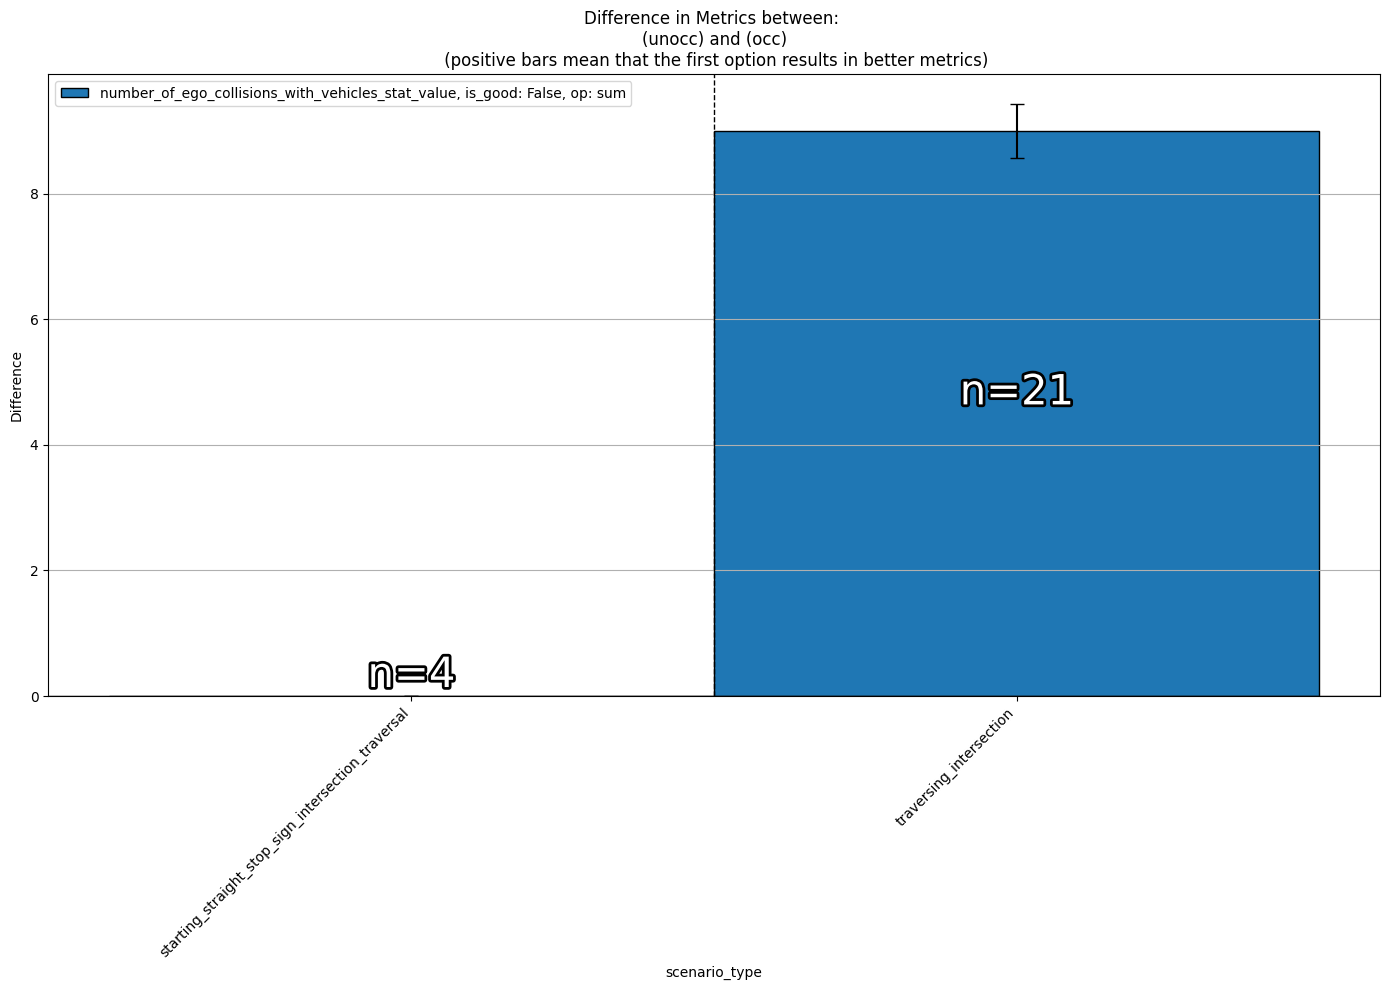

In [14]:
from vis_utils import plot_diff

# %env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
# %env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
# %env NUPLAN_EXP_ROOT=../../data/nuplan/exp
# %env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
# %pwd

# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.05.29.17"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.05.36.28"
# )

file_path_1 = output_folder_unocc + "/metrics/" + "no_ego_at_fault_collisions.parquet"
file_path_2 = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"


metrics = [
    "number_of_ego_collisions_with_vehicles_stat_value",
]
metric_op = [
    "sum",
]
# metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [
    False,
]

plot_diff(
    file_path_1,
    file_path_2,
    "unocc",
    "occ",
    metrics,
    metric_op,
    good_metric,
    group_by="scenario_type",
    k_differences=25,
    as_bool=True,
)

## Prepare the nuBoard config

In [15]:
# import hydra

# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.55.22"

output_folder = [output_folder_occ, output_folder_unocc]

# output_folder = [output_folder_occ]
print(output_folder_occ)
print(output_folder_unocc)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.09.12.26
../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.24.09.51.37


## Launch nuBoard (open in new tab - recommended)


In [16]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-04-24 10:00:35,292 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-04-24 10:00:35,310 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-04-24 10:00:35,311 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-04-24 10:00:35,311 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-04-24 10:00:35,311 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-04-24 10:00:35,311 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

2024-04-24 10:00:36,342 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-04-24 10:00:36,393 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0015 seconds.
2024-04-24 10:00:36,493 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 403.82ms


INFO:tornado.access:200 GET / (127.0.0.1) 403.82ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.54ms


2024-04-24 10:00:37,240 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.54ms
2024-04-24 10:00:37,240 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-04-24 10:00:37,240 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created
2024-04-24 10:00:37,987 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-04-24 10:00:38,037 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0015 seconds.
2024-04-24 10:00:38,129 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 383.02ms


INFO:tornado.access:200 GET / (127.0.0.1) 383.02ms
(raylet) [2024-04-24 10:00:42,809 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498561011712; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 10:00:52,812 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498560876544; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 10:01:02,814 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% full, available space: 498560868352; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-24 10:01:12,816 E 734528 734540] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-24_09-51-40_993603_719196 is over 95% ful